### Import Modules & Basic Settings

In [1]:
import os, time
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Set Options

In [2]:
# GPU Setting
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = "cuda:0"
else: 
    device = "cpu"
print('Device:', device)

# Number of CPU cores
num_cores = os.cpu_count()
print(f"Number of CPU Cores: {num_cores}")

# Base Directory
root_dir = os.getcwd()
print(f'Base Directory: {os.getcwd()}')

# Path to Data
image_data = '/data/image/'
train_data_path = root_dir+image_data+'train/'
test_data_path = root_dir+image_data+'test/'

Device: cuda:0
Number of CPU Cores: 32
Base Directory: /home/jiwon/GalaxyClassification


In [3]:
# Hyper-Parameters Setting
criterion = torch.nn.CrossEntropyLoss()
batch_size = 32
max_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-5
val_interval = 1

### Load Train Data

In [4]:
# Set Label (Train)
train_df = pd.read_csv(os.path.join(train_data_path, 'training_solutions_rev1.csv'))
print(train_df.shape)
print(train_df.columns)

(61578, 38)
Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')


In [5]:
train_df['Label'] = train_df.iloc[:, 1:].idxmax(axis=1)
train_df = train_df[['GalaxyID', 'Label']]
print(train_df)

       GalaxyID     Label
0        100008  Class6.2
1        100023  Class6.2
2        100053  Class6.2
3        100078  Class1.1
4        100090  Class6.2
...         ...       ...
61573    999948  Class6.2
61574    999950  Class1.1
61575    999958  Class6.1
61576    999964  Class1.2
61577    999967  Class1.1

[61578 rows x 2 columns]


In [6]:
# Custom Dataset
class GalaxyDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f"{self.labels_df['GalaxyID'].iloc[idx]}.jpg")
        image = Image.open(img_name).convert('RGB')
        label = int(self.labels_df.iloc[idx, -1].split('.')[0].replace('Class', '')) - 1

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [7]:
# Define Dataset & Data Loader
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = GalaxyDataset(train_data_path, train_df, transform=transform)
val_dataset = GalaxyDataset(train_data_path, val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=16, pin_memory=True)

In [8]:
# Extract First Batch
tr_batch_first = next(iter(train_dataset))
print(f'Image Shape: {tr_batch_first[0].shape}')
print(f'Label Type: {type(tr_batch_first[1])}')

Image Shape: torch.Size([3, 128, 128])
Label Type: <class 'int'>


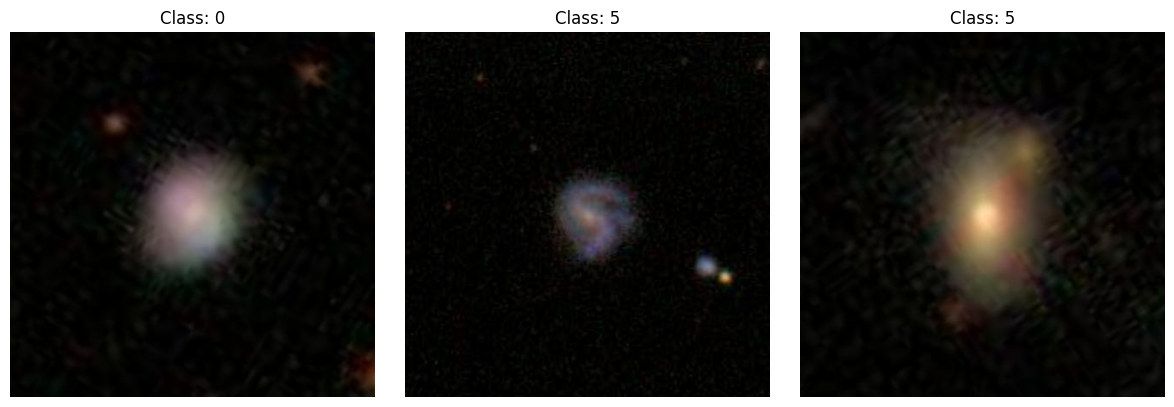

In [9]:
# Visualize: Train
visualize_num = 3
space = 0 if visualize_num%3==0 else 1
plt.figure(figsize=(12, 4*(visualize_num//3+space)))

for i in range(3):
    img_name = os.path.join(train_data_path, f"{train_df['GalaxyID'].iloc[i]}.jpg")
    image = Image.open(img_name).convert('RGB')
    label = int(val_df.iloc[i, -1].split('.')[0].replace('Class', '')) - 1

    plt.subplot(visualize_num//3+space, 3, i+1)
    plt.imshow(image)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

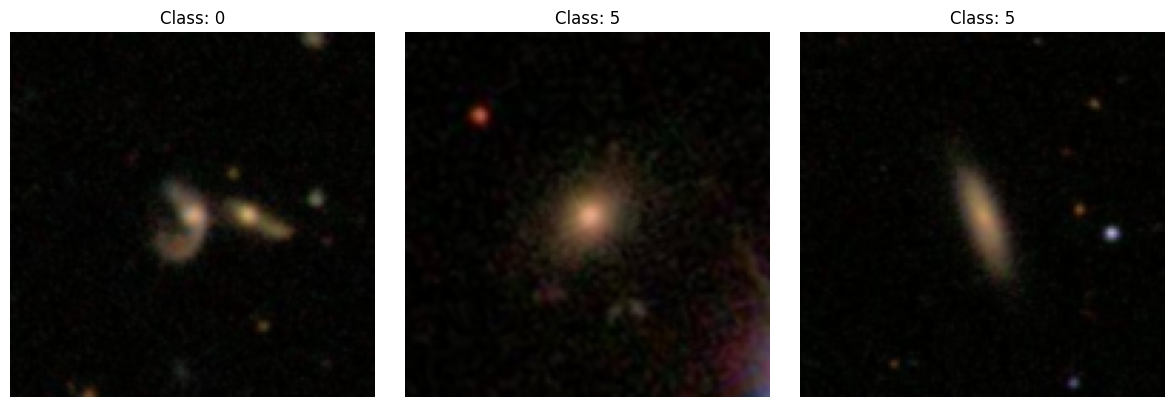

In [10]:
# Visualize: Val
visualize_num = 3
space = 0 if visualize_num%3==0 else 1
plt.figure(figsize=(12, 4*(visualize_num//3+space)))

train_loader_iter = iter(val_dataset)

for i in range(visualize_num):
    image, label = next(train_loader_iter)
    image = image.permute(1, 2, 0).numpy()

    plt.subplot(visualize_num//3+space, 3, i+1)
    plt.imshow(image)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Model

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
# # Hyper-Parameters Setting
# criterion = torch.nn.CrossEntropyLoss()
# batch_size = 32
# max_epochs = 100
# learning_rate = 1e-4
# weight_decay = 1e-5
# val_interval = 1

In [13]:
# Model, Optimizer, and Scheduler Setup
num_classes = 37
model = SimpleCNN(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [14]:
print('Device:', device)
print(torch.cuda.is_available())

Device: cuda:0
True


In [15]:
from tqdm import tqdm

# Initialize variables for tracking loss and metric values
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, epoch_metric_values, metric_values = [], [], []

# Training Loop
start_time = time.time()
num_epochs = 200

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss = 0.0
    correct_predictions, total_samples = 0, 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

         # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=running_loss/(len(progress_bar)), accuracy=correct_predictions / total_samples)

    # Calculate epoch average loss
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    epoch_loss_values.append(epoch_loss)
    epoch_metric_values.append(epoch_accuracy)
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} ({int(epoch_time)} sec)")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_accuracy = correct / total
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

    metric_values.append(validation_accuracy)

    if validation_accuracy > best_metric:
        best_metric = validation_accuracy
        best_metric_epoch = epoch + 1
        best_model_wts = model.state_dict()

    lr_scheduler.step()
    epoch_end_time = time.time()

# Save the model
torch.save(best_model_wts, os.path.join(root_dir,'galaxy_cnn_model.pth'))

# Total training time
total_time = time.time() - start_time
print()
print(f"Best accuracy: {best_metric:.3f} at epoch {best_metric_epoch}; Total time consumed: {total_time//60} mins {int(total_time%60)} sec")

# Save loss and metric values
torch.save({
    'epoch_loss_values': epoch_loss_values,
    'epoch_metric_values': epoch_metric_values,
    'metric_values': metric_values
}, 'training_metrics.pth')

Epoch [1/200], Loss: 0.6446, Accuracy: 0.6600 (198 sec)


Validation Accuracy: 0.6850


Epoch [2/200], Loss: 0.5894, Accuracy: 0.6920 (183 sec)


Validation Accuracy: 0.6870


Epoch [3/200], Loss: 0.5733, Accuracy: 0.7048 (215 sec)


Validation Accuracy: 0.7077


Epoch [4/200], Loss: 0.5581, Accuracy: 0.7183 (258 sec)


Validation Accuracy: 0.7141


Epoch [5/200], Loss: 0.5443, Accuracy: 0.7271 (257 sec)


Validation Accuracy: 0.7235


Epoch [6/200], Loss: 0.5298, Accuracy: 0.7407 (261 sec)


Validation Accuracy: 0.7299


Epoch [7/200], Loss: 0.5126, Accuracy: 0.7512 (262 sec)


Validation Accuracy: 0.7335


Epoch [8/200], Loss: 0.4982, Accuracy: 0.7607 (266 sec)


Validation Accuracy: 0.7429


Epoch [9/200], Loss: 0.4815, Accuracy: 0.7715 (262 sec)


Validation Accuracy: 0.7427


Epoch [10/200], Loss: 0.4663, Accuracy: 0.7850 (264 sec)


Validation Accuracy: 0.7427


Epoch [11/200], Loss: 0.4522, Accuracy: 0.7944 (264 sec)


Validation Accuracy: 0.7424


Epoch [12/200], Loss: 0.4351, Accuracy: 0.8040 (256 sec)


Validation Accuracy: 0.7492


Epoch [13/200], Loss: 0.4158, Accuracy: 0.8135 (254 sec)


Validation Accuracy: 0.7353


Epoch [14/200], Loss: 0.3952, Accuracy: 0.8268 (213 sec)


Validation Accuracy: 0.7389


Epoch [15/200], Loss: 0.3747, Accuracy: 0.8361 (179 sec)


Validation Accuracy: 0.7403


Epoch [16/200], Loss: 0.3528, Accuracy: 0.8503 (175 sec)


Validation Accuracy: 0.7224


Epoch [17/200], Loss: 0.3290, Accuracy: 0.8612 (175 sec)


Validation Accuracy: 0.7427


Epoch [18/200], Loss: 0.3079, Accuracy: 0.8720 (180 sec)


Validation Accuracy: 0.7401


Epoch [19/200], Loss: 0.2845, Accuracy: 0.8822 (182 sec)


Validation Accuracy: 0.7375


Epoch [20/200], Loss: 0.2618, Accuracy: 0.8921 (182 sec)


Validation Accuracy: 0.7328


Epoch [21/200], Loss: 0.2446, Accuracy: 0.9022 (171 sec)


Validation Accuracy: 0.7423


Epoch [22/200], Loss: 0.2258, Accuracy: 0.9105 (171 sec)


Validation Accuracy: 0.7390


Epoch [23/200], Loss: 0.2057, Accuracy: 0.9190 (181 sec)


Validation Accuracy: 0.7304


Epoch [24/200], Loss: 0.1893, Accuracy: 0.9262 (182 sec)


Validation Accuracy: 0.7342


Epoch [25/200], Loss: 0.1707, Accuracy: 0.9341 (180 sec)


Validation Accuracy: 0.7349


Epoch [26/200], Loss: 0.1577, Accuracy: 0.9395 (178 sec)


Validation Accuracy: 0.7231


Epoch [27/200], Loss: 0.1426, Accuracy: 0.9462 (185 sec)


Validation Accuracy: 0.7082


Epoch [28/200], Loss: 0.1321, Accuracy: 0.9509 (170 sec)


Validation Accuracy: 0.7373


Epoch [29/200], Loss: 0.1220, Accuracy: 0.9551 (174 sec)


Validation Accuracy: 0.7373


Epoch [30/200], Loss: 0.1074, Accuracy: 0.9611 (183 sec)


Validation Accuracy: 0.7342


Epoch [31/200], Loss: 0.1001, Accuracy: 0.9642 (179 sec)


Validation Accuracy: 0.7339


Epoch [32/200], Loss: 0.0923, Accuracy: 0.9677 (174 sec)


Validation Accuracy: 0.7272


Epoch [33/200], Loss: 0.0845, Accuracy: 0.9700 (180 sec)


Validation Accuracy: 0.7363


Epoch [34/200], Loss: 0.0767, Accuracy: 0.9728 (178 sec)


Validation Accuracy: 0.7322


Epoch [35/200], Loss: 0.0694, Accuracy: 0.9767 (176 sec)


Validation Accuracy: 0.7386


Epoch [36/200], Loss: 0.0651, Accuracy: 0.9778 (177 sec)


Validation Accuracy: 0.7315


Epoch [37/200], Loss: 0.0591, Accuracy: 0.9802 (177 sec)


Validation Accuracy: 0.7270


Epoch [38/200], Loss: 0.0582, Accuracy: 0.9798 (180 sec)


Validation Accuracy: 0.7364


Epoch [39/200], Loss: 0.0511, Accuracy: 0.9828 (184 sec)


Validation Accuracy: 0.7345


Epoch [40/200], Loss: 0.0467, Accuracy: 0.9850 (175 sec)


Validation Accuracy: 0.7359


Epoch [41/200], Loss: 0.0438, Accuracy: 0.9856 (188 sec)


Validation Accuracy: 0.7362


Epoch [42/200], Loss: 0.0416, Accuracy: 0.9873 (182 sec)


Validation Accuracy: 0.7386


Epoch [43/200], Loss: 0.0400, Accuracy: 0.9870 (180 sec)


Validation Accuracy: 0.7365


Epoch [44/200], Loss: 0.0335, Accuracy: 0.9895 (183 sec)


Validation Accuracy: 0.7330


Epoch [45/200], Loss: 0.0334, Accuracy: 0.9895 (177 sec)


Validation Accuracy: 0.7304


Epoch [46/200], Loss: 0.0312, Accuracy: 0.9901 (162 sec)


Validation Accuracy: 0.7338


Epoch [47/200], Loss: 0.0289, Accuracy: 0.9914 (183 sec)


Validation Accuracy: 0.7355


Epoch [48/200], Loss: 0.0272, Accuracy: 0.9912 (180 sec)


Validation Accuracy: 0.7360


Epoch [49/200], Loss: 0.0253, Accuracy: 0.9921 (188 sec)


Validation Accuracy: 0.7346


Epoch [50/200], Loss: 0.0245, Accuracy: 0.9922 (178 sec)


Validation Accuracy: 0.7307


Epoch [51/200], Loss: 0.0225, Accuracy: 0.9927 (180 sec)


Validation Accuracy: 0.7388


Epoch [52/200], Loss: 0.0214, Accuracy: 0.9935 (184 sec)


Validation Accuracy: 0.7352


Epoch [53/200], Loss: 0.0204, Accuracy: 0.9939 (182 sec)


Validation Accuracy: 0.7396


Epoch [54/200], Loss: 0.0201, Accuracy: 0.9939 (187 sec)


Validation Accuracy: 0.7446


Epoch [55/200], Loss: 0.0179, Accuracy: 0.9947 (180 sec)


Validation Accuracy: 0.7351


Epoch [56/200], Loss: 0.0180, Accuracy: 0.9948 (178 sec)


Validation Accuracy: 0.7356


Epoch [57/200], Loss: 0.0172, Accuracy: 0.9950 (181 sec)


Validation Accuracy: 0.7361


Epoch [58/200], Loss: 0.0163, Accuracy: 0.9955 (176 sec)


Validation Accuracy: 0.7367


Epoch [59/200], Loss: 0.0151, Accuracy: 0.9955 (189 sec)


Validation Accuracy: 0.7374


Epoch [60/200], Loss: 0.0136, Accuracy: 0.9960 (177 sec)


Validation Accuracy: 0.7386


Epoch [61/200], Loss: 0.0135, Accuracy: 0.9962 (175 sec)


Validation Accuracy: 0.7351


Epoch [62/200], Loss: 0.0133, Accuracy: 0.9960 (181 sec)


Validation Accuracy: 0.7333


Epoch [63/200], Loss: 0.0128, Accuracy: 0.9965 (184 sec)


Validation Accuracy: 0.7352


Epoch [64/200], Loss: 0.0112, Accuracy: 0.9970 (172 sec)


Validation Accuracy: 0.7377


Epoch [65/200], Loss: 0.0104, Accuracy: 0.9973 (176 sec)


Validation Accuracy: 0.7345


Epoch [66/200], Loss: 0.0102, Accuracy: 0.9971 (179 sec)


Validation Accuracy: 0.7374


Epoch [67/200], Loss: 0.0100, Accuracy: 0.9974 (173 sec)


Validation Accuracy: 0.7395


Epoch [68/200], Loss: 0.0086, Accuracy: 0.9976 (180 sec)


Validation Accuracy: 0.7416


Epoch [69/200], Loss: 0.0100, Accuracy: 0.9972 (181 sec)


Validation Accuracy: 0.7398


Epoch [70/200], Loss: 0.0082, Accuracy: 0.9977 (177 sec)


Validation Accuracy: 0.7416


Epoch [71/200], Loss: 0.0087, Accuracy: 0.9978 (177 sec)


Validation Accuracy: 0.7407


Epoch [72/200], Loss: 0.0087, Accuracy: 0.9978 (174 sec)


Validation Accuracy: 0.7390


Epoch [73/200], Loss: 0.0078, Accuracy: 0.9979 (178 sec)


Validation Accuracy: 0.7376


Epoch [74/200], Loss: 0.0069, Accuracy: 0.9983 (177 sec)


Validation Accuracy: 0.7378


Epoch [75/200], Loss: 0.0069, Accuracy: 0.9984 (178 sec)


Validation Accuracy: 0.7436


Epoch [76/200], Loss: 0.0063, Accuracy: 0.9984 (178 sec)


Validation Accuracy: 0.7384


Epoch [77/200], Loss: 0.0064, Accuracy: 0.9983 (179 sec)


Validation Accuracy: 0.7395


Epoch [78/200], Loss: 0.0063, Accuracy: 0.9984 (176 sec)


Validation Accuracy: 0.7396


Epoch [79/200], Loss: 0.0055, Accuracy: 0.9985 (167 sec)


Validation Accuracy: 0.7387


Epoch [80/200], Loss: 0.0061, Accuracy: 0.9985 (176 sec)


Validation Accuracy: 0.7394


Epoch [81/200], Loss: 0.0047, Accuracy: 0.9987 (180 sec)


Validation Accuracy: 0.7395


Epoch [82/200], Loss: 0.0055, Accuracy: 0.9984 (179 sec)


Validation Accuracy: 0.7426


Epoch [83/200], Loss: 0.0051, Accuracy: 0.9988 (178 sec)


Validation Accuracy: 0.7386


Epoch [84/200], Loss: 0.0057, Accuracy: 0.9986 (176 sec)


Validation Accuracy: 0.7420


Epoch [85/200], Loss: 0.0043, Accuracy: 0.9988 (169 sec)


Validation Accuracy: 0.7424


Epoch [86/200], Loss: 0.0047, Accuracy: 0.9988 (182 sec)


Validation Accuracy: 0.7438


Epoch [87/200], Loss: 0.0048, Accuracy: 0.9988 (173 sec)


Validation Accuracy: 0.7429


Epoch [88/200], Loss: 0.0044, Accuracy: 0.9989 (180 sec)


Validation Accuracy: 0.7439


Epoch [89/200], Loss: 0.0044, Accuracy: 0.9988 (180 sec)


Validation Accuracy: 0.7411


Epoch [90/200], Loss: 0.0040, Accuracy: 0.9990 (180 sec)


Validation Accuracy: 0.7429


Epoch [91/200], Loss: 0.0041, Accuracy: 0.9991 (178 sec)


Validation Accuracy: 0.7413


Epoch [92/200], Loss: 0.0039, Accuracy: 0.9989 (178 sec)


Validation Accuracy: 0.7440


Epoch [93/200], Loss: 0.0041, Accuracy: 0.9989 (177 sec)


Validation Accuracy: 0.7435


Epoch [94/200], Loss: 0.0038, Accuracy: 0.9992 (154 sec)


Validation Accuracy: 0.7424


Epoch [95/200], Loss: 0.0048, Accuracy: 0.9989 (180 sec)


Validation Accuracy: 0.7428


Epoch [96/200], Loss: 0.0042, Accuracy: 0.9990 (177 sec)


Validation Accuracy: 0.7430


Epoch [97/200], Loss: 0.0043, Accuracy: 0.9990 (182 sec)


Validation Accuracy: 0.7427


Epoch [98/200], Loss: 0.0035, Accuracy: 0.9992 (183 sec)


Validation Accuracy: 0.7429


Epoch [99/200], Loss: 0.0038, Accuracy: 0.9989 (174 sec)


Validation Accuracy: 0.7427


Epoch [100/200], Loss: 0.0040, Accuracy: 0.9990 (174 sec)


Validation Accuracy: 0.7427


Epoch [101/200], Loss: 0.0046, Accuracy: 0.9988 (184 sec)


Validation Accuracy: 0.7427


Epoch [102/200], Loss: 0.0040, Accuracy: 0.9991 (173 sec)


Validation Accuracy: 0.7428


Epoch [103/200], Loss: 0.0038, Accuracy: 0.9991 (173 sec)


Validation Accuracy: 0.7429


Epoch [104/200], Loss: 0.0043, Accuracy: 0.9989 (177 sec)


Validation Accuracy: 0.7427


Epoch [105/200], Loss: 0.0039, Accuracy: 0.9990 (177 sec)


Validation Accuracy: 0.7426


Epoch [106/200], Loss: 0.0042, Accuracy: 0.9989 (178 sec)


Validation Accuracy: 0.7433


Epoch [107/200], Loss: 0.0038, Accuracy: 0.9991 (181 sec)


Validation Accuracy: 0.7429


Epoch [108/200], Loss: 0.0036, Accuracy: 0.9992 (180 sec)


Validation Accuracy: 0.7428


Epoch [109/200], Loss: 0.0042, Accuracy: 0.9989 (183 sec)


Validation Accuracy: 0.7404


Epoch [110/200], Loss: 0.0041, Accuracy: 0.9990 (173 sec)


Validation Accuracy: 0.7417


Epoch [111/200], Loss: 0.0044, Accuracy: 0.9988 (172 sec)


Validation Accuracy: 0.7426


Epoch [112/200], Loss: 0.0039, Accuracy: 0.9990 (173 sec)


Validation Accuracy: 0.7437


Epoch [113/200], Loss: 0.0043, Accuracy: 0.9989 (182 sec)


Validation Accuracy: 0.7414


Epoch [114/200], Loss: 0.0036, Accuracy: 0.9991 (188 sec)


Validation Accuracy: 0.7403


Epoch [115/200], Loss: 0.0037, Accuracy: 0.9993 (186 sec)


Validation Accuracy: 0.7417


Epoch [116/200], Loss: 0.0045, Accuracy: 0.9988 (177 sec)


Validation Accuracy: 0.7429


Epoch [117/200], Loss: 0.0042, Accuracy: 0.9989 (171 sec)


Validation Accuracy: 0.7437


Epoch [118/200], Loss: 0.0041, Accuracy: 0.9990 (179 sec)


Validation Accuracy: 0.7429


Epoch [119/200], Loss: 0.0043, Accuracy: 0.9988 (173 sec)


Validation Accuracy: 0.7433


Epoch [120/200], Loss: 0.0048, Accuracy: 0.9988 (177 sec)


Validation Accuracy: 0.7424


Epoch [121/200], Loss: 0.0045, Accuracy: 0.9990 (177 sec)


Validation Accuracy: 0.7437


Epoch [122/200], Loss: 0.0048, Accuracy: 0.9987 (178 sec)


Validation Accuracy: 0.7416


Epoch [123/200], Loss: 0.0044, Accuracy: 0.9990 (178 sec)


Validation Accuracy: 0.7404


Epoch [124/200], Loss: 0.0049, Accuracy: 0.9987 (174 sec)


Validation Accuracy: 0.7429


Epoch [125/200], Loss: 0.0045, Accuracy: 0.9989 (183 sec)


Validation Accuracy: 0.7424


Epoch [126/200], Loss: 0.0043, Accuracy: 0.9990 (178 sec)


Validation Accuracy: 0.7403


Epoch [127/200], Loss: 0.0041, Accuracy: 0.9989 (195 sec)


Validation Accuracy: 0.7415


Epoch [128/200], Loss: 0.0051, Accuracy: 0.9986 (182 sec)


Validation Accuracy: 0.7414


Epoch [129/200], Loss: 0.0046, Accuracy: 0.9988 (179 sec)


Validation Accuracy: 0.7414


Epoch [130/200], Loss: 0.0055, Accuracy: 0.9986 (183 sec)


Validation Accuracy: 0.7383


Epoch [131/200], Loss: 0.0045, Accuracy: 0.9989 (184 sec)


Validation Accuracy: 0.7399


Epoch [132/200], Loss: 0.0074, Accuracy: 0.9980 (178 sec)


Validation Accuracy: 0.7404


Epoch [133/200], Loss: 0.0061, Accuracy: 0.9985 (184 sec)


Validation Accuracy: 0.7437


Epoch [134/200], Loss: 0.0073, Accuracy: 0.9979 (180 sec)


Validation Accuracy: 0.7428


Epoch [135/200], Loss: 0.0068, Accuracy: 0.9980 (178 sec)


Validation Accuracy: 0.7433


Epoch [136/200], Loss: 0.0067, Accuracy: 0.9980 (187 sec)


Validation Accuracy: 0.7452


Epoch [137/200], Loss: 0.0070, Accuracy: 0.9981 (173 sec)


Validation Accuracy: 0.7418


Epoch [138/200], Loss: 0.0072, Accuracy: 0.9978 (172 sec)


Validation Accuracy: 0.7354


Epoch [139/200], Loss: 0.0073, Accuracy: 0.9980 (179 sec)


Validation Accuracy: 0.7410


Epoch [140/200], Loss: 0.0075, Accuracy: 0.9979 (178 sec)


Validation Accuracy: 0.7397


Epoch [141/200], Loss: 0.0084, Accuracy: 0.9977 (159 sec)


Validation Accuracy: 0.7376


Epoch [142/200], Loss: 0.0094, Accuracy: 0.9976 (183 sec)


Validation Accuracy: 0.7424


Epoch [143/200], Loss: 0.0100, Accuracy: 0.9972 (173 sec)


Validation Accuracy: 0.7389


Epoch [144/200], Loss: 0.0101, Accuracy: 0.9971 (177 sec)


Validation Accuracy: 0.7389


Epoch [145/200], Loss: 0.0095, Accuracy: 0.9976 (183 sec)


Validation Accuracy: 0.7403


Epoch [146/200], Loss: 0.0100, Accuracy: 0.9972 (183 sec)


Validation Accuracy: 0.7346


Epoch [147/200], Loss: 0.0109, Accuracy: 0.9969 (177 sec)


Validation Accuracy: 0.7441


Epoch [148/200], Loss: 0.0126, Accuracy: 0.9962 (175 sec)


Validation Accuracy: 0.7323


Epoch [149/200], Loss: 0.0126, Accuracy: 0.9964 (175 sec)


Validation Accuracy: 0.7423


Epoch [150/200], Loss: 0.0105, Accuracy: 0.9971 (179 sec)


Validation Accuracy: 0.7426


Epoch [151/200], Loss: 0.0134, Accuracy: 0.9959 (186 sec)


Validation Accuracy: 0.7369


Epoch [152/200], Loss: 0.0131, Accuracy: 0.9962 (181 sec)


Validation Accuracy: 0.7406


Epoch [153/200], Loss: 0.0141, Accuracy: 0.9960 (178 sec)


Validation Accuracy: 0.7386


Epoch [154/200], Loss: 0.0141, Accuracy: 0.9957 (174 sec)


Validation Accuracy: 0.7402


Epoch [155/200], Loss: 0.0157, Accuracy: 0.9957 (178 sec)


Validation Accuracy: 0.7357


Epoch [156/200], Loss: 0.0197, Accuracy: 0.9937 (181 sec)


Validation Accuracy: 0.7343


Epoch [157/200], Loss: 0.0172, Accuracy: 0.9949 (178 sec)


Validation Accuracy: 0.7290


Epoch [158/200], Loss: 0.0155, Accuracy: 0.9953 (179 sec)


Validation Accuracy: 0.7370


Epoch [159/200], Loss: 0.0187, Accuracy: 0.9940 (181 sec)


Validation Accuracy: 0.7377


Epoch [160/200], Loss: 0.0197, Accuracy: 0.9936 (168 sec)


Validation Accuracy: 0.7374


Epoch [161/200], Loss: 0.0198, Accuracy: 0.9937 (174 sec)


Validation Accuracy: 0.7403


Epoch [162/200], Loss: 0.0216, Accuracy: 0.9933 (175 sec)


Validation Accuracy: 0.7288


Epoch [163/200], Loss: 0.0185, Accuracy: 0.9942 (167 sec)


Validation Accuracy: 0.7379


Epoch [164/200], Loss: 0.0194, Accuracy: 0.9940 (175 sec)


Validation Accuracy: 0.7328


Epoch [165/200], Loss: 0.0210, Accuracy: 0.9933 (177 sec)


Validation Accuracy: 0.7340


Epoch [166/200], Loss: 0.0208, Accuracy: 0.9935 (176 sec)


Validation Accuracy: 0.7388


Epoch [167/200], Loss: 0.0216, Accuracy: 0.9933 (172 sec)


Validation Accuracy: 0.7364


Epoch [168/200], Loss: 0.0212, Accuracy: 0.9933 (172 sec)


Validation Accuracy: 0.7374


Epoch [169/200], Loss: 0.0227, Accuracy: 0.9922 (174 sec)


Validation Accuracy: 0.7330


Epoch [170/200], Loss: 0.0206, Accuracy: 0.9936 (173 sec)


Validation Accuracy: 0.7359


Epoch [171/200], Loss: 0.0244, Accuracy: 0.9922 (177 sec)


Validation Accuracy: 0.7345


Epoch [172/200], Loss: 0.0231, Accuracy: 0.9926 (173 sec)


Validation Accuracy: 0.7326


Epoch [173/200], Loss: 0.0235, Accuracy: 0.9927 (175 sec)


Validation Accuracy: 0.7305


Epoch [174/200], Loss: 0.0238, Accuracy: 0.9920 (170 sec)


Validation Accuracy: 0.7385


Epoch [175/200], Loss: 0.0228, Accuracy: 0.9927 (168 sec)


Validation Accuracy: 0.7341


Epoch [176/200], Loss: 0.0266, Accuracy: 0.9919 (175 sec)


Validation Accuracy: 0.7383


Epoch [177/200], Loss: 0.0247, Accuracy: 0.9927 (177 sec)


Validation Accuracy: 0.7403


Epoch [178/200], Loss: 0.0255, Accuracy: 0.9919 (176 sec)


Validation Accuracy: 0.7296


Epoch [179/200], Loss: 0.0230, Accuracy: 0.9922 (178 sec)


Validation Accuracy: 0.7354


Epoch [180/200], Loss: 0.0263, Accuracy: 0.9914 (173 sec)


Validation Accuracy: 0.7364


Epoch [181/200], Loss: 0.0238, Accuracy: 0.9921 (169 sec)


Validation Accuracy: 0.7400


Epoch [182/200], Loss: 0.0262, Accuracy: 0.9913 (173 sec)


Validation Accuracy: 0.7306


Epoch [183/200], Loss: 0.0250, Accuracy: 0.9920 (179 sec)


Validation Accuracy: 0.7328


Epoch [184/200], Loss: 0.0219, Accuracy: 0.9929 (174 sec)


Validation Accuracy: 0.7330


Epoch [185/200], Loss: 0.0244, Accuracy: 0.9917 (185 sec)


Validation Accuracy: 0.7348


Epoch [186/200], Loss: 0.0268, Accuracy: 0.9913 (178 sec)


Validation Accuracy: 0.7307


Epoch [187/200], Loss: 0.0241, Accuracy: 0.9926 (209 sec)


Validation Accuracy: 0.7317


Epoch [188/200], Loss: 0.0226, Accuracy: 0.9923 (246 sec)


Validation Accuracy: 0.7364


Epoch [189/200], Loss: 0.0274, Accuracy: 0.9912 (223 sec)


Validation Accuracy: 0.7271


Epoch [190/200], Loss: 0.0256, Accuracy: 0.9918 (242 sec)


Validation Accuracy: 0.7341


Epoch [191/200], Loss: 0.0258, Accuracy: 0.9921 (247 sec)


Validation Accuracy: 0.7363


Epoch [192/200], Loss: 0.0248, Accuracy: 0.9917 (249 sec)


Validation Accuracy: 0.7321


Epoch [193/200], Loss: 0.0238, Accuracy: 0.9919 (242 sec)


Validation Accuracy: 0.7330


Epoch [194/200], Loss: 0.0236, Accuracy: 0.9924 (244 sec)


Validation Accuracy: 0.7309


Epoch [195/200], Loss: 0.0236, Accuracy: 0.9928 (246 sec)


Validation Accuracy: 0.7380


Epoch [196/200], Loss: 0.0236, Accuracy: 0.9924 (247 sec)


Validation Accuracy: 0.7321


Epoch [197/200], Loss: 0.0239, Accuracy: 0.9922 (251 sec)


Validation Accuracy: 0.7355


Epoch [198/200], Loss: 0.0237, Accuracy: 0.9925 (243 sec)


Validation Accuracy: 0.7331


Epoch [199/200], Loss: 0.0253, Accuracy: 0.9916 (252 sec)


Validation Accuracy: 0.7314


Epoch [200/200], Loss: 0.0221, Accuracy: 0.9925 (249 sec)


Validation Accuracy: 0.7335

Best accuracy: 0.749 at epoch 12; Total time consumed: 794.0 mins 21 sec


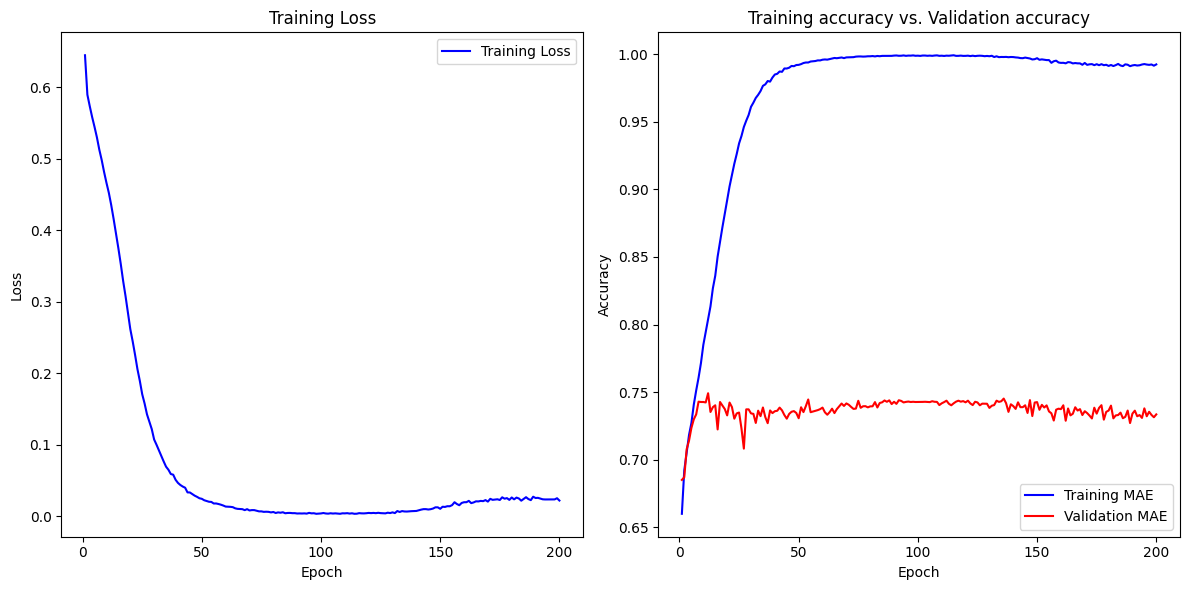

In [16]:
# Plotting the Results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[0].plot([i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values, label='Training Loss', color='blue')
axes[0].legend()

axes[1].set_title('Training accuracy vs. Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.linspace(0,1,5)*len(epoch_metric_values))
axes[1].plot([i + 1 for i in range(len(epoch_metric_values))], epoch_metric_values, label='Training MAE', color='blue')
axes[1].plot([val_interval * (i + 1) for i in range(len(metric_values))], metric_values, label='Validation MAE', color='red')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(root_dir, "Performance.png"), dpi=300)